### Checking output of Conv Encoder TransposeDecoder

In [1]:
cd ..

/home/agajan/DeepMRI


In [2]:
import torch
import torch.nn as nn
from deepmri.Datasets import Volume3dDataset
import deepmri.utils as utils
from DiffusionMRI.ConvEncoder import ConvEncoder
from DiffusionMRI.ConvTransposeDecoder import ConvTransposeDecoder
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import time
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [4]:
mu = 307.3646240234375
std = 763.4876098632812
batch_size = 1
data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/'
validset = Volume3dDataset(data_path + 'tensors_3d/', mu=mu, std=std)
# validset = Volume3dDataset(data_path + 'smallset/train/', mu=mu, std=std)
idx = torch.randint(low=0, high=len(validset)+1, size=(1,))
# idx = 0
data = validset[idx].unsqueeze(0) # add batch dim
x_coord = 100
y_coord = 87
z_coord = 73
print("Total examples: ", len(validset))
print("Test volume index: ", idx)
print("DiffusionMRI 1 Volume shape:", data.shape)
print("Minimum voxel value: {}, Maximum voxel value: {}".format(torch.min(data), torch.max(data)))

Total examples:  40669
Test volume index:  tensor([24397])
DiffusionMRI 1 Volume shape: torch.Size([1, 1, 145, 174, 145])
Minimum voxel value: -0.40257972478866577, Maximum voxel value: 7.101229190826416


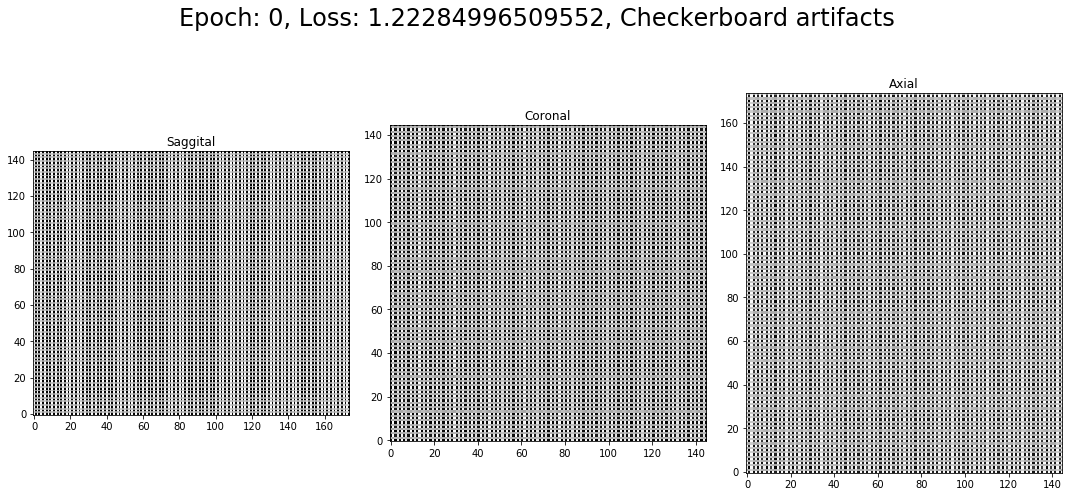

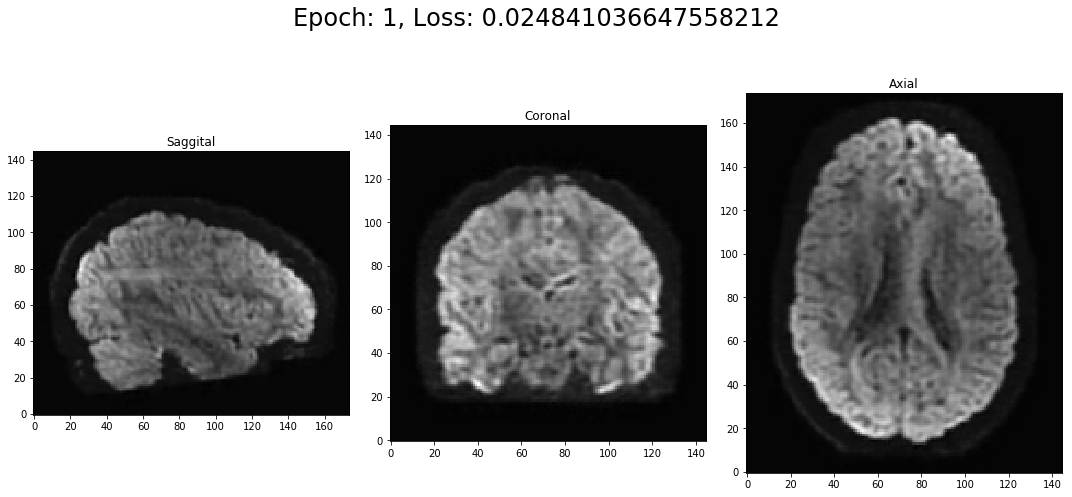

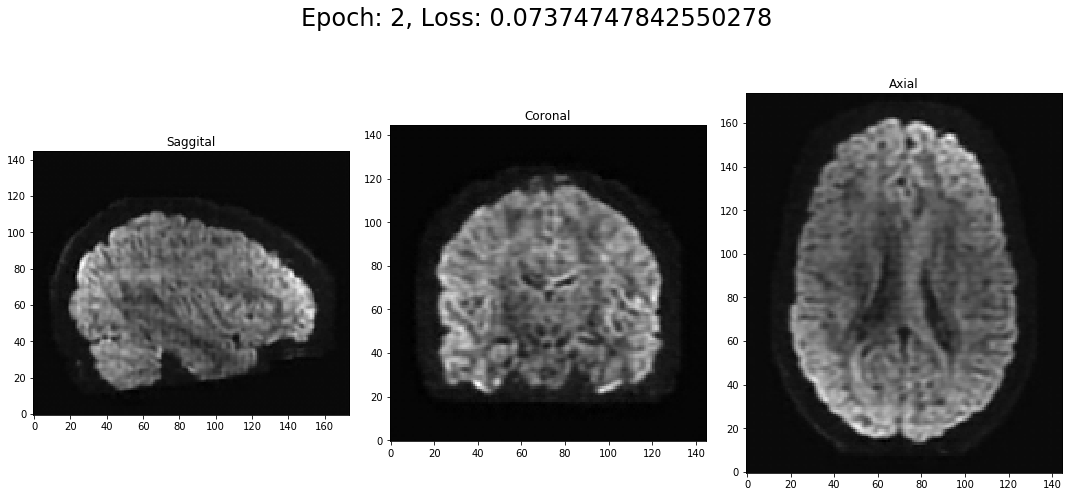

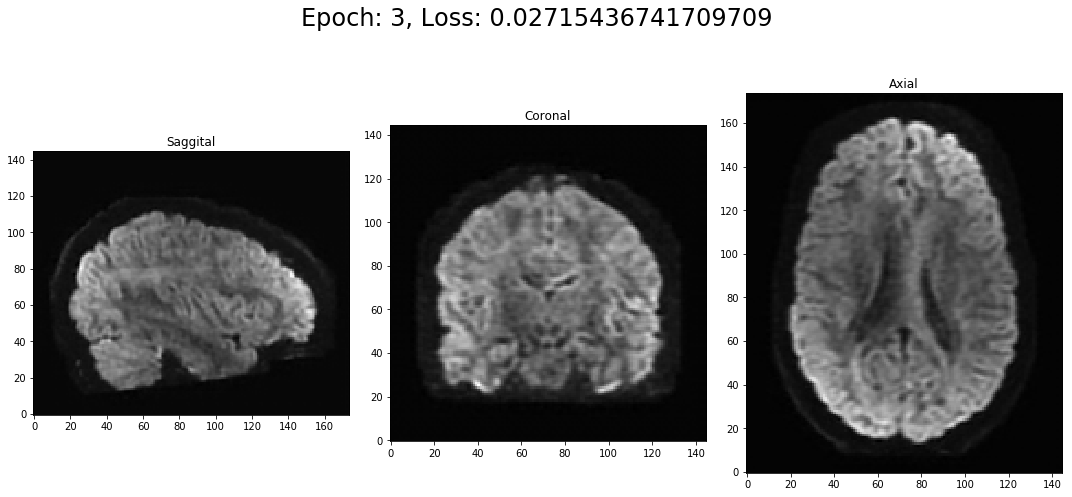

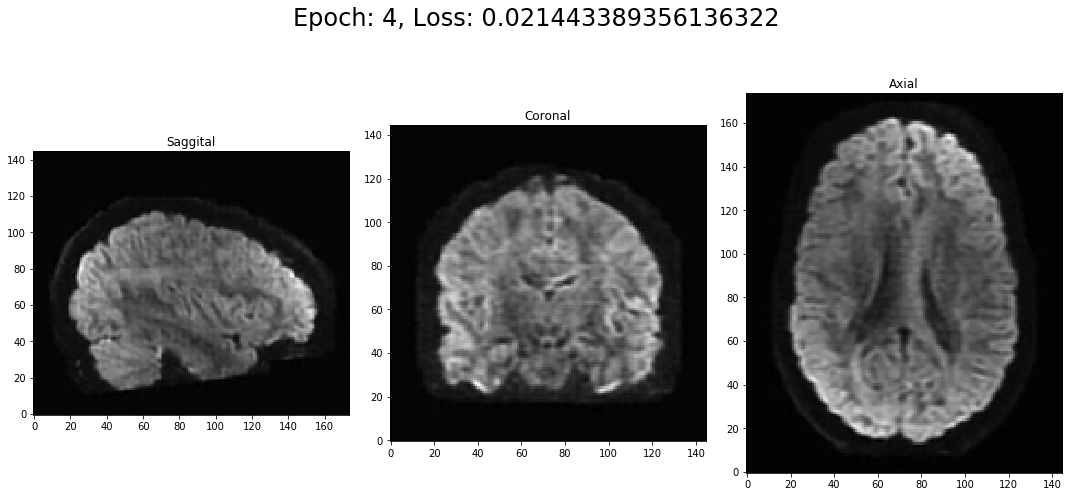

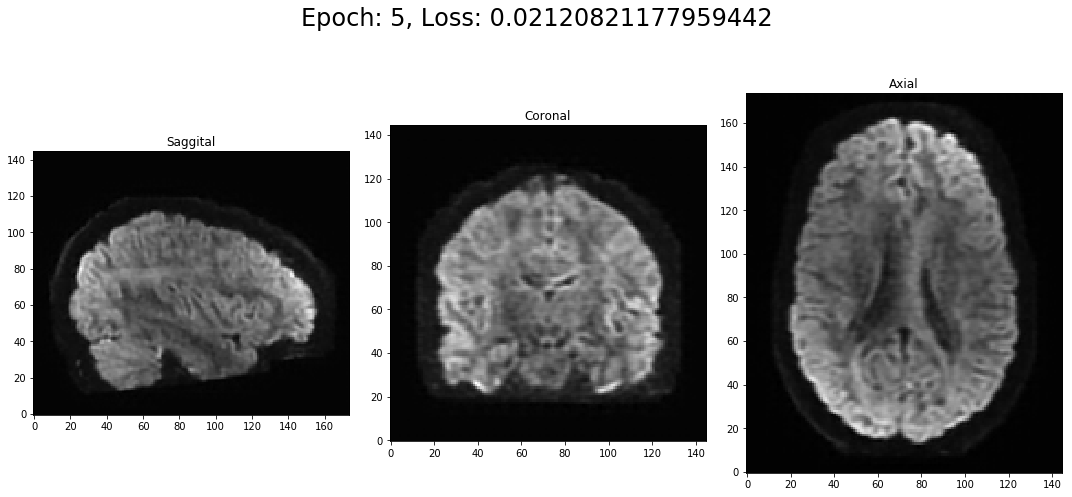

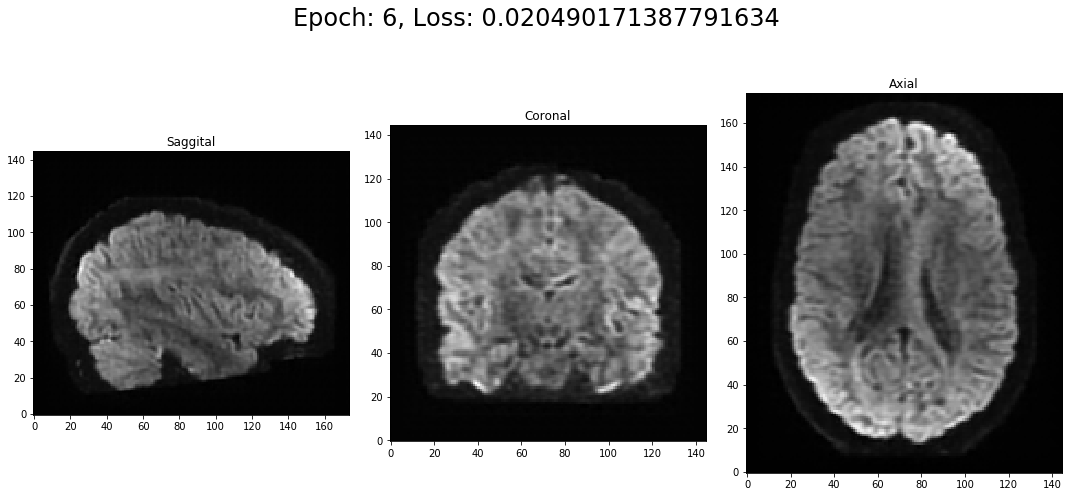

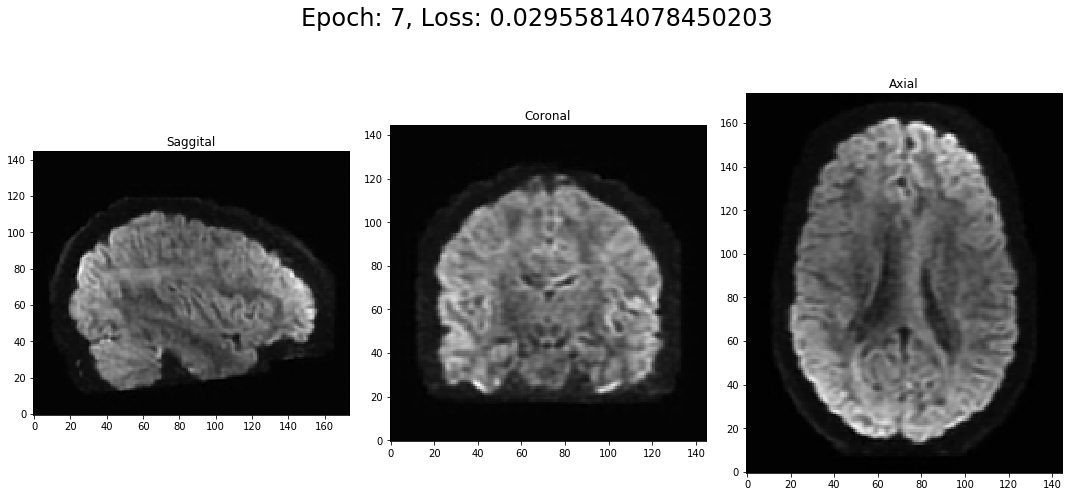

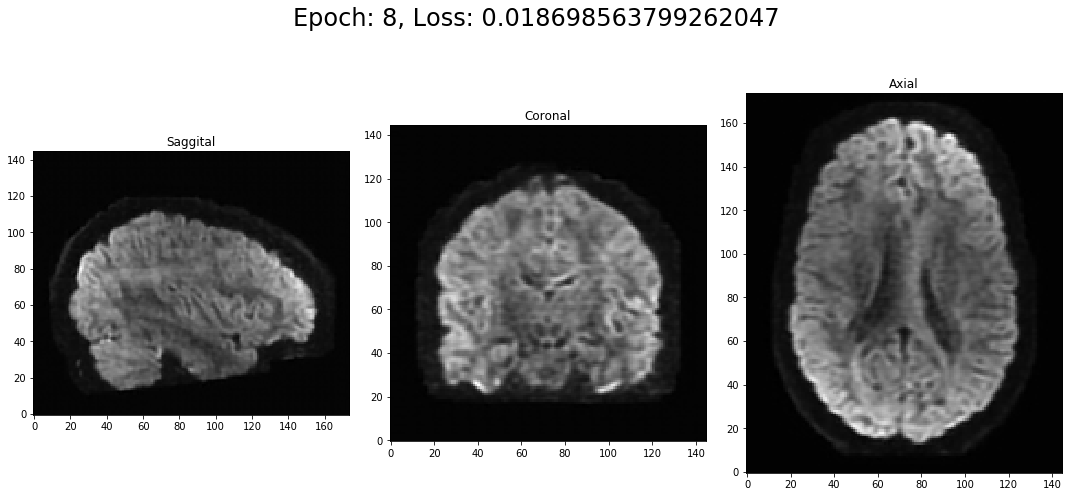

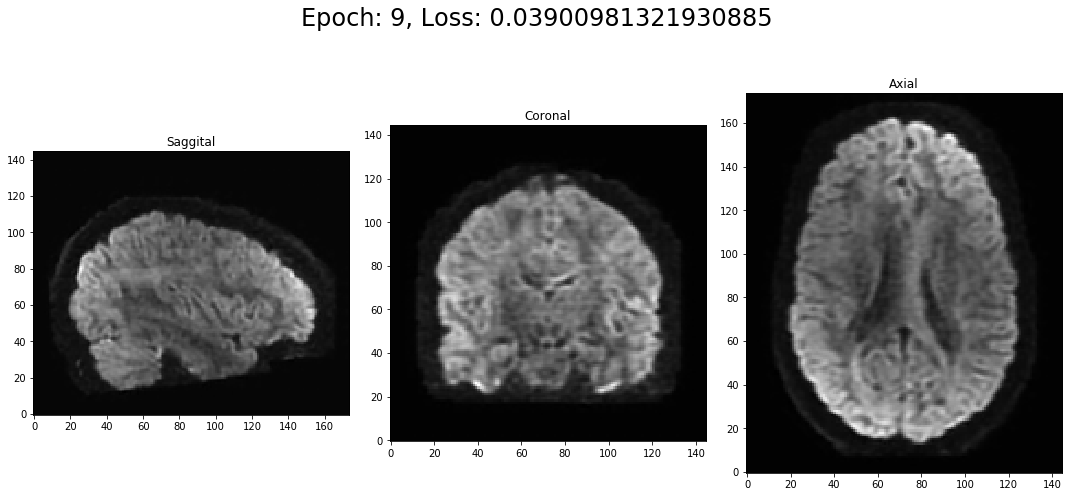

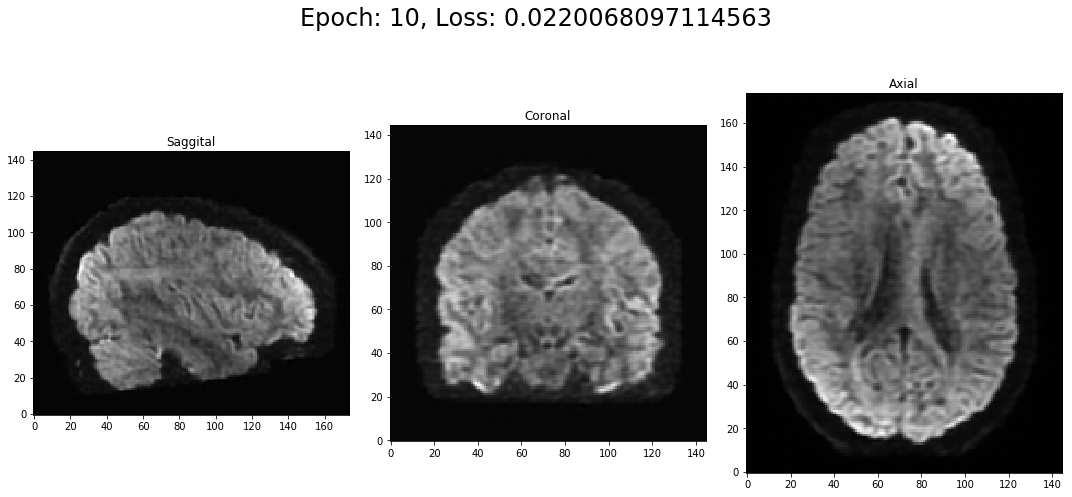

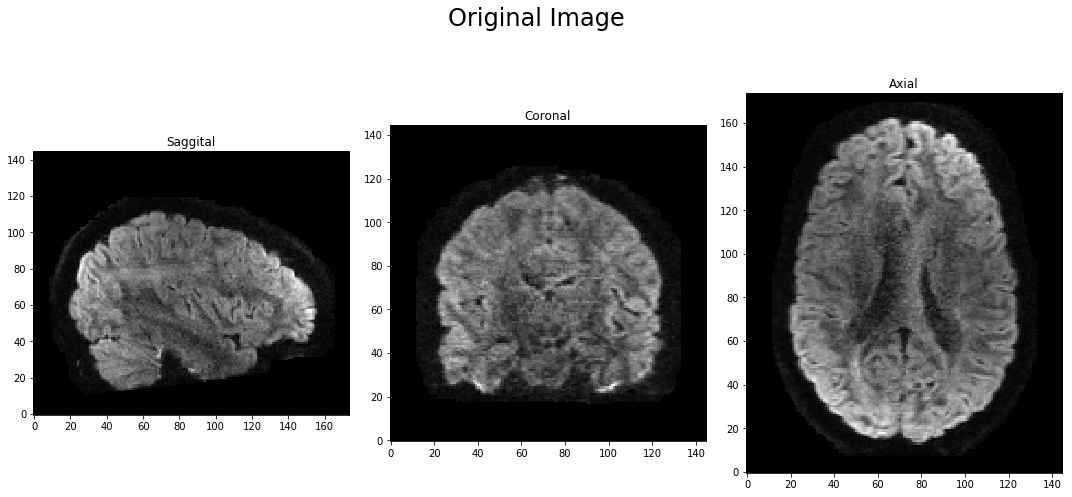

In [5]:
encoder = ConvEncoder(input_channels=1)
encoder.to(device)
encoder.eval()

decoder = ConvTransposeDecoder(out_channels=1)
decoder.to(device)
decoder.eval()

criterion = nn.MSELoss()

# before training
with torch.no_grad():
    running_loss = 0.0
    encoder.eval()
    decoder.eval()
    
    x = data.to(device)
    out_0 = decoder(encoder(x))
    loss = criterion(x, out_0)
    running_loss += loss.item() * data.size(0)

epoch_loss = running_loss / 1.
suptitle = "Epoch: {}, Loss: {}, Checkerboard artifacts".format(0, epoch_loss)
utils.show_slices([
    out_0[0, 0, x_coord, :, :].cpu().numpy(),
    out_0[0, 0, :, y_coord, :].cpu().numpy(),
    out_0[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(15, 8), suptitle=suptitle)
    
# show progress
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for epoch in epochs:
    encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/adj_transpose_conv_encoder_epoch_' + str(epoch)
    decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/adj_transpose_conv_decoder_epoch_' + str(epoch)
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    with torch.no_grad():
        running_loss = 0.0
        encoder.eval()
        decoder.eval()
        x = data.to(device)
        out = decoder(encoder(x))
        loss = criterion(x, out)
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / 1.
    suptitle = "Epoch: {}, Loss: {}".format(epoch, epoch_loss)
    utils.show_slices([
        out[0, 0, x_coord, :, :].cpu().numpy(),
        out[0, 0, :, y_coord, :].cpu().numpy(),
        out[0, 0, :, :, z_coord].cpu().numpy(),
    ], figsize=(15, 8), suptitle=suptitle)

# show original image
utils.show_slices([
    data[0, 0, x_coord, :, :].cpu().numpy(),
    data[0, 0, :, y_coord, :].cpu().numpy(),
    data[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(15, 8), suptitle="Original Image")

In [6]:
print("Original data: min={}, max={}, ".format(data.min(), data.max()))
print("Reconstructed data: min={}, max={}, ".format(out.min(), out.max()))
print("Loss between original and epoch 0 (normalized): {}".format(criterion(data, out_0.cpu())))
print("Loss between original and last epoch (normalized): {}".format(criterion(data, out.cpu())))
print("Loss between original and epoch 0 (unnormalized): {}".
      format(criterion(data * std + mu, out_0.cpu()*std + mu)))
print("Loss between original and last epoch (unnormalized): {}".
      format(criterion(data * std + mu, out.cpu()*std + mu)))
print("Loss between original and last epoch (unnormalized, zero clamped): {}".
      format(criterion(data * std + mu, (out.cpu()*std + mu).clamp(min=0) )))

Original data: min=-0.40257972478866577, max=7.101229190826416, 
Reconstructed data: min=-1.0288971662521362, max=7.355271816253662, 
Loss between original and epoch 0 (normalized): 1.2228498458862305
Loss between original and last epoch (normalized): 0.02200680784881115
Loss between original and epoch 0 (unnormalized): 712815.5
Loss between original and last epoch (unnormalized): 12828.0615234375
Loss between original and last epoch (unnormalized, zero clamped): 12142.4775390625


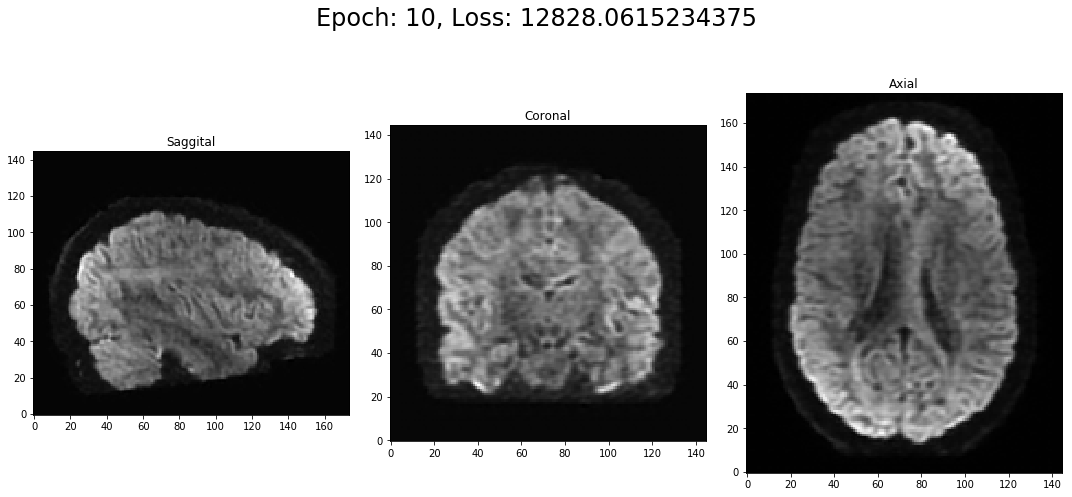

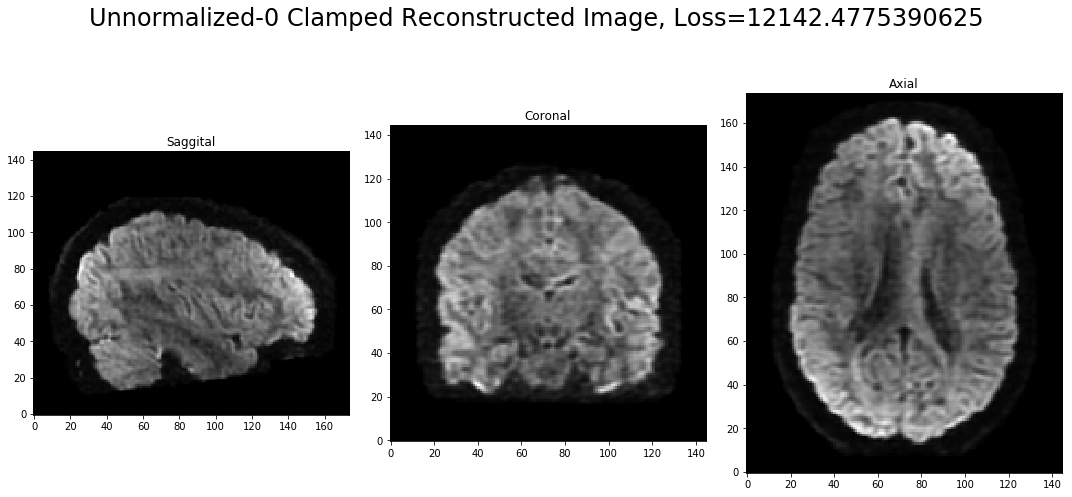

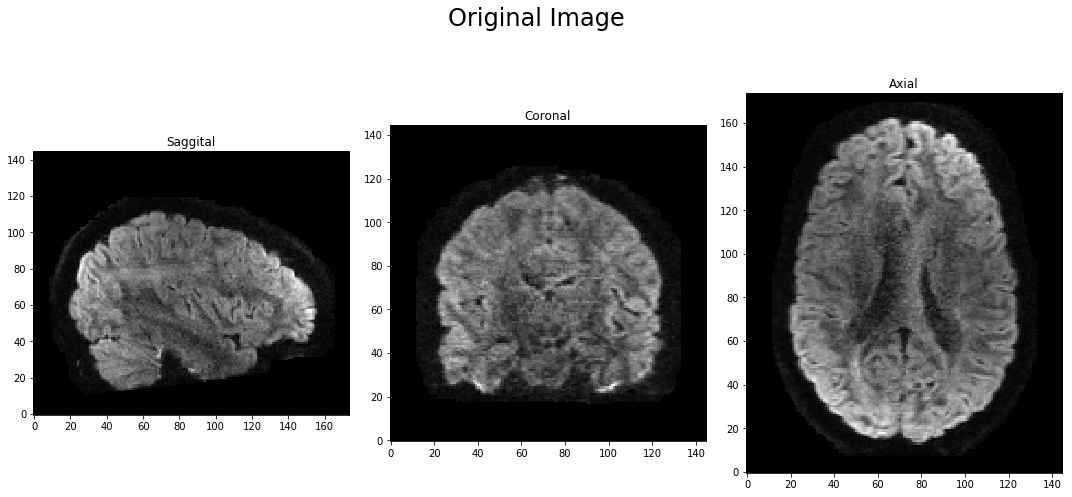

In [7]:
unnormalized_original_data = data * std  + mu
reconstructed = (out.cpu()*std + mu)

suptitle = "Epoch: {}, Loss: {}".format(10, criterion(unnormalized_original_data, reconstructed))
utils.show_slices([
    out[0, 0, x_coord, :, :].cpu().numpy(),
    out[0, 0, :, y_coord, :].cpu().numpy(),
    out[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(15, 8), suptitle=suptitle)
tmp = reconstructed.clone()

reconstructed = reconstructed.clamp(min=0)
loss = criterion(unnormalized_original_data, reconstructed)
suptitle = "Unnormalized-0 Clamped Reconstructed Image, Loss={}".format(loss.item())
utils.show_slices([
        reconstructed[0, 0, x_coord, :, :].numpy(),
        reconstructed[0, 0, :, y_coord, :].cpu().numpy(),
        reconstructed[0, 0, :, :, z_coord].cpu().numpy(),
    ], figsize=(15, 8), suptitle=suptitle)

# show original image
utils.show_slices([
    unnormalized_original_data[0, 0, x_coord, :, :].cpu().numpy(),
    unnormalized_original_data[0, 0, :, y_coord, :].cpu().numpy(),
    unnormalized_original_data[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(15, 8), suptitle="Original Image")